# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


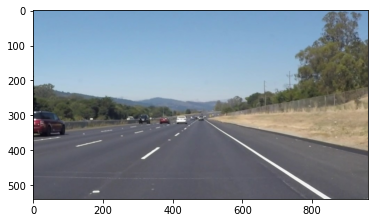

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines_img(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns hough lines
    """
    return cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidYellowCurve.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
def getImages():
    '''Gets a list of images from the test_images directory'''
    images = []
    for imgPath in os.listdir("test_images/"):
        images.append(mpimg.imread('test_images/{}'.format(imgPath)))
    return images

In [20]:
def process_image(image, displayMidProcessImages=False):
    """Finds lane lines of the image and returns the original image with the lane lines added.
    """
    
    ## Tunable parameters
    kernelSize = 5  # Must be odd. Eg. 3, 5, 7
    
    lowThreshold = 10
    highThreshold = 120
    
    roiHeightRatio = 40/100
    roiLongWidthRatio = 90/100
    roiShortWidthRatio = 4/100
    
    rho = 2
    theta = np.pi / 180
    threshold = 30
    minLineLen = 15
    maxLineGap = 10
    
    ## Helper methods
    def getRegionOfInterest(width, height, roiHeightRatio, roiLongWidthRatio, roiShortWidthRatio):
        '''Gets the region of interest of an image with the given image dimensions and roi ratios'''
        wideBorderX = width*(1-roiLongWidthRatio)/2
        narrowBorderX = width*(1-roiShortWidthRatio)/2
        yMax = height
        yMin = height * (1 - roiHeightRatio)
        return np.array([[(wideBorderX, yMax),
                          (narrowBorderX, yMin),
                          (width-narrowBorderX, yMin),
                          (width-wideBorderX, yMax),
                          (width-3*wideBorderX, yMax),
                          (width/2, (yMax+yMin)*1/2),
                          (3*wideBorderX, yMax),

                          ]], dtype=np.int32)

    def displayImages(imagesByName):
        '''Display mid-process images'''
        fig, axs = plt.subplots(int((len(imagesByName)+1)/2), 2, figsize=(15, 10))
        fig.tight_layout()

        for i in range(len(imagesByName)):
            imageName, image = imagesByName[i]
            axs[int(i/2)][i%2].imshow(image) 
            axs[int(i/2)][i%2].set_title('{}'.format(imageName))

    def filterLines(lines, width):
        '''Removes lines that do not have a valid slope for their location'''
        # Only keep lines that are sloped in the right direction
        # based on the side of the image that it is on
        filteredLines = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                # Handle edge case
                if x1 == x2:
                    filteredLines.append(line)
                    continue
                
                slope = (y2-y1)/(x2-x1)
                centerX = (x2 + x1)/2
                isSlopeValidForLocation = (slope > 0.5 and centerX > width/2) or (slope < -0.5 and centerX < width/2)
                if isSlopeValidForLocation:
                    filteredLines.append(line)
        return filteredLines
    
    def convertToTwoLines(lines, width, yMax, yMin):
        '''Converts lines into two lines through averaging''' 
        
        def findWeightedAverageSlopeAndIntercept2(lines, directionHint='right'):
            if len(lines) == 0:
                print("Length of lines is 0. Giving back dummy values for slope and intercept")
                if directionHint == 'right':
                    if hasattr(findWeightedAverageSlopeAndIntercept2, 'lastPositiveSlopeIntercept'):
                        print("Right cache")
                        return findWeightedAverageSlopeAndIntercept2.lastPositiveSlopeIntercept
                    print("No Right cache")
                    return 0.6, 25
                else:
                    if hasattr(findWeightedAverageSlopeAndIntercept2, 'lastNegativeSlopeIntercept'):
                        print("Left cache")
                        return findWeightedAverageSlopeAndIntercept2.lastNegativeSlopeIntercept
                    print("No Left cache")
                    return -0.7, 640
            else:
                print("Normal")

            totalRho = 0
            totalTheta = 0
            for line in lines:
                for x1,y1,x2,y2 in line:
                    if x2 == x1:
                        x2 += 0.001
                    slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
                    theta = math.atan(-1/slope)
                    rho = intercept * math.sin(theta)
                    totalRho += rho
                    totalTheta += theta
            avgRho = totalRho/len(lines)
            avgTheta = totalTheta/len(lines)

            avgSlope = -1/math.tan(avgTheta)
            avgIntercept = avgRho/math.sin(avgTheta)
            if avgSlope > 0:
                findWeightedAverageSlopeAndIntercept2.lastPositiveSlopeIntercept = (avgSlope, avgIntercept)
            else:
                findWeightedAverageSlopeAndIntercept2.lastNegativeSlopeIntercept = (avgSlope, avgIntercept)

            return avgSlope, avgIntercept
        
        def findWeightedAverageSlopeAndIntercept(lines):
            if len(lines) == 0:
                print("Length of lines is 0. Giving back dummy values for slope and intercept")
                return 1, 1

            totalAngle = 0
            totalIntercept = 0
            totalLength = 0
            for line in lines:
                for x1,y1,x2,y2 in line:
                    length = ((x1-x2)**2+(y1-y2)**2)
                    if x1 == x2:
                        x2 += 0.01
                    slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
                    totalAngle += math.atan2(slope, 1)*length
                    totalIntercept += intercept*length
                    totalLength += length
            return math.tan(totalAngle/totalLength), totalIntercept/totalLength
        
        def findMedianSlopeAndIntercept(lines):
            if len(lines) == 0:
                print("Length of lines is 0. Giving back dummy values for slope and intercept")
                return 1, 1

            angles = []
            intercepts = []
            lengths = []
            for line in lines:
                for x1,y1,x2,y2 in line:
                    length = ((x1-x2)**2+(y1-y2)**2)
                    if x1 == x2:
                        x2 += 0.01
                    slope, intercept = np.polyfit((x1, x2), (y1, y2), 1)
                    angles.append(math.atan2(slope, 1))
                    intercepts.append(intercept)
                    lengths.append(length)
                    
            import statistics
            medianAngle = statistics.median(angles)
            medianIntercept = statistics.median(intercepts)
            reducedAngles = []
            for angle in angles:
                reducedAngles.append(abs(angle - medianAngle))
            originalLength = len(reducedAngles)
#             while len(angles) > originalLength * 1 / 4:
            while len(angles) > 3:
                indexOfWorst = reducedAngles.index(max(reducedAngles))
                reducedAngles.pop(indexOfWorst)
                angles.pop(indexOfWorst)
                intercepts.pop(indexOfWorst)
                lengths.pop(indexOfWorst)

            totalAngle = 0
            totalIntercept = 0
            totalLength = 0
            for i in range(len(angles)):
                totalAngle += angles[i] * lengths[i]
                totalIntercept += intercepts[i] * lengths[i]
                totalLength += lengths[i]
            
            return math.tan(totalAngle/totalLength), totalIntercept/totalLength
        
        def findLeftAndRightLines(lines):
            rightLines = []
            leftLines = []
            for line in lines:
                for x1,y1,x2,y2 in line:
                    slope = (y2-y1)/(x2-x1)
                    if slope > 0:
                        rightLines.append(line)
                    else:
                        leftLines.append(line)
            return leftLines, rightLines

        def createLine(m, b, y1, y2):
            x1 = int((y1-b)/m)
            x2 = int((y2-b)/m)
            y1 = int(y1)
            y2 = int(y2)
            return (x1, y1, x2, y2)
    
        # Get the average slope/intercept for the left and right line
        leftLines, rightLines = findLeftAndRightLines(lines)
#         avgLeftSlope, avgLeftIntercept = findWeightedAverageSlopeAndIntercept(leftLines)
#         avgRightSlope, avgRightIntercept = findWeightedAverageSlopeAndIntercept(rightLines)
        avgLeftSlope, avgLeftIntercept = findWeightedAverageSlopeAndIntercept2(leftLines, 'left')
        avgRightSlope, avgRightIntercept = findWeightedAverageSlopeAndIntercept2(rightLines, 'right')
#         avgLeftSlope, avgLeftIntercept = findMedianSlopeAndIntercept(leftLines)
#         avgRightSlope, avgRightIntercept = findMedianSlopeAndIntercept(rightLines)

        # Return the lines
        leftLine = createLine(avgLeftSlope, avgLeftIntercept, yMax, yMin)
        rightLine = createLine(avgRightSlope, avgRightIntercept, yMax, yMin)
        return [[leftLine], [rightLine]]

    def createLineImage(lines, height, width, channels):
        linesImage = np.zeros((height, width, channels), dtype=np.uint8)
        draw_lines(linesImage, lines, thickness=5)
        return linesImage
    
    # Calculations which will be useful for future parts
    height, width, channels = image.shape
    
    # Step 1: Convert to grayscale for proper edge detection
    grayImage = grayscale(image)

    # Step 2: Perform Gaussian Blur to remove noise
    blurredGrayImage = gaussian_blur(grayImage, kernelSize)

    # Step 3: Perform Canny edge detection
    edgesImage = canny(blurredGrayImage, lowThreshold, highThreshold)
    
    # Step 4: Only look at region of interest
    roi = getRegionOfInterest(width, height, roiHeightRatio, roiLongWidthRatio, roiShortWidthRatio)
    edgesImageRoi = region_of_interest(edgesImage, roi)
    
    # Step 5: Find lines with hough transform
    houghLines = hough_lines(edgesImageRoi, rho, theta, threshold, minLineLen, maxLineGap)
    
    # Step 6: Filter the hough lines
    filteredLines = filterLines(houghLines, width)
    filteredLinesImage = createLineImage(filteredLines, height, width, channels)

    # Step 7: Convert the filtered hough lines to two lines by averaging
    twoLines = convertToTwoLines(filteredLines, width, height, height * (1 - roiHeightRatio))
    twoLinesImage = createLineImage(twoLines, height, width, channels)
    
    allLinesImage = createLineImage(filteredLines, height, width, channels)
    draw_lines(allLinesImage, twoLines, color=[0,255,0], thickness=5)

    # Step 8: Draw lines on original image
#     processedImage = weighted_img(cv2.cvtColor(edgesImageRoi,cv2.COLOR_GRAY2RGB), image, α=.1, β=1.)
#     processedImage = weighted_img(filteredLinesImage, image, α=.7, β=1.)
#     processedImage = weighted_img(twoLinesImage, image, α=.7, β=1.)
    processedImage = weighted_img(allLinesImage, image, α=.7, β=1.)

    # Display images in process, if desired
    if displayMidProcessImages:
        imagesByName = [('grayImage', grayImage),
                        ('blurredGrayImage', blurredGrayImage),
                        ('edgesImage', edgesImage),
                        ('edgesImageRoi', edgesImageRoi),
                        ('filteredLinesImage', filteredLinesImage),
                        ('twoLinesImage', twoLinesImage),
                        ('processedImage', processedImage)
                       ]
        displayImages(imagesByName)

    return processedImage

Normal
Normal


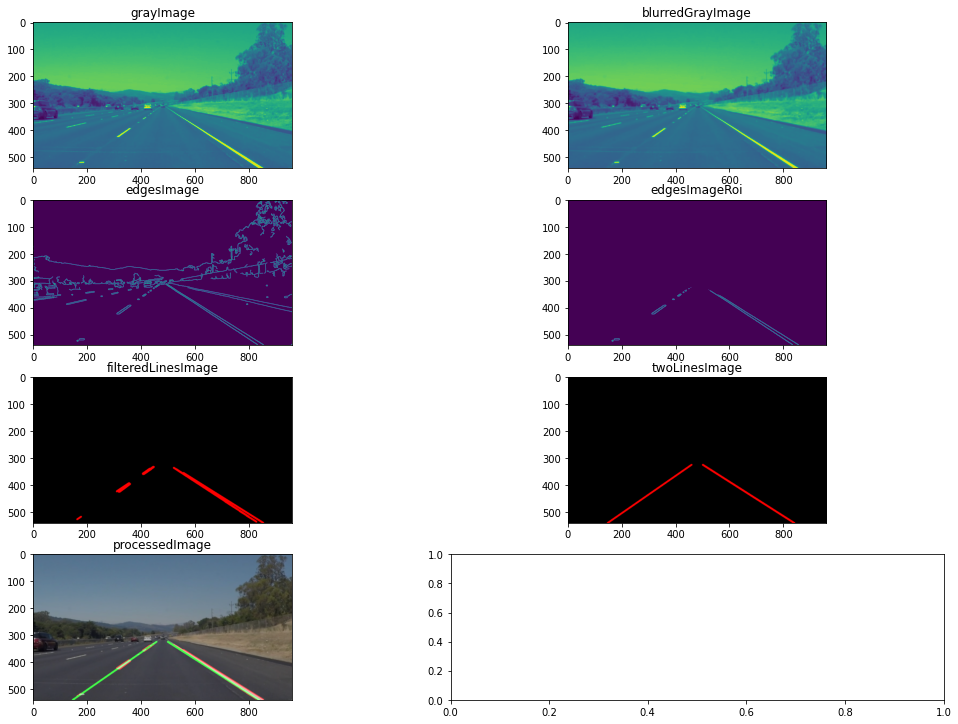

In [18]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = getImages()

processedImage = process_image(images[2], True)

-0.7175676081210691
656.3948885125882
*****
0.581598897993721
36.35312536409021
*****
-0.768497988568579
676.9372100061163
*****
0.5657554139552612
37.83250561154194
*****
-0.6937362794360881
641.8300286409388
*****
0.6349860534357209
6.785150383796579
*****
-0.6876205055657708
637.1500923111668
*****
0.6340575955105193
1.7841691713878942
*****
-0.7841974566515014
689.5991601580209
*****
0.5637863175985175
41.33938734558994
*****
-0.764991240953472
672.6851338463028
*****
0.5944156855600617
24.422054863704144
*****


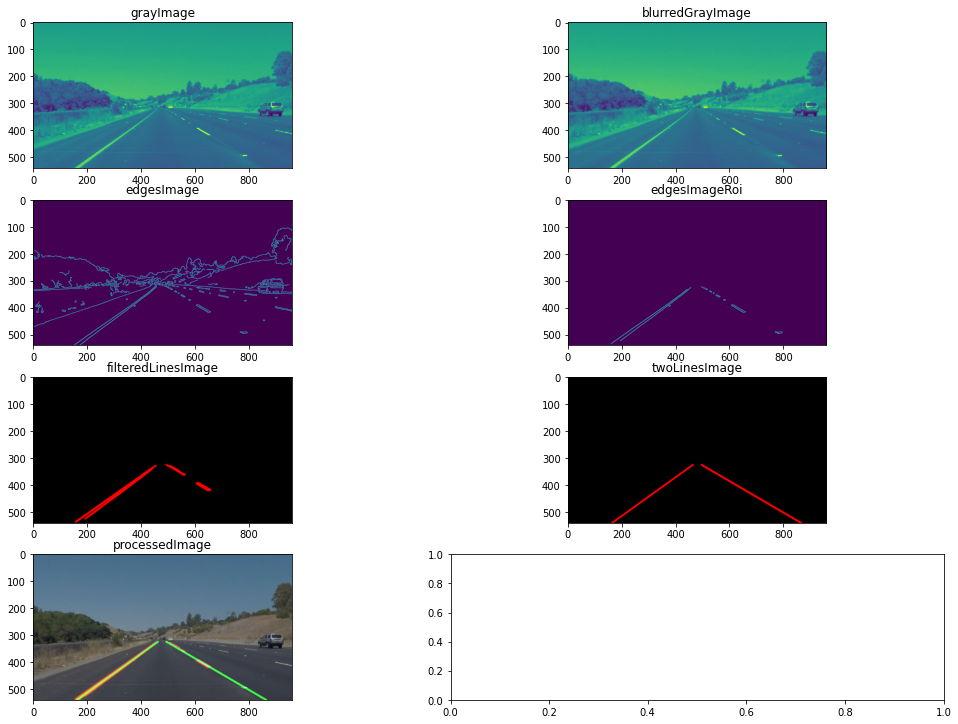

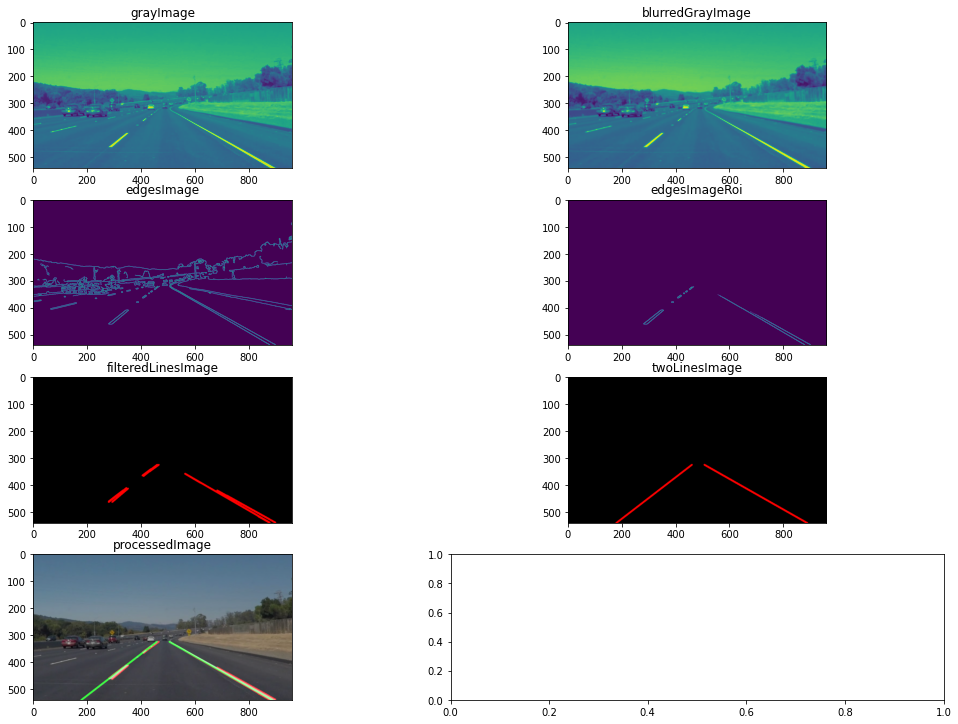

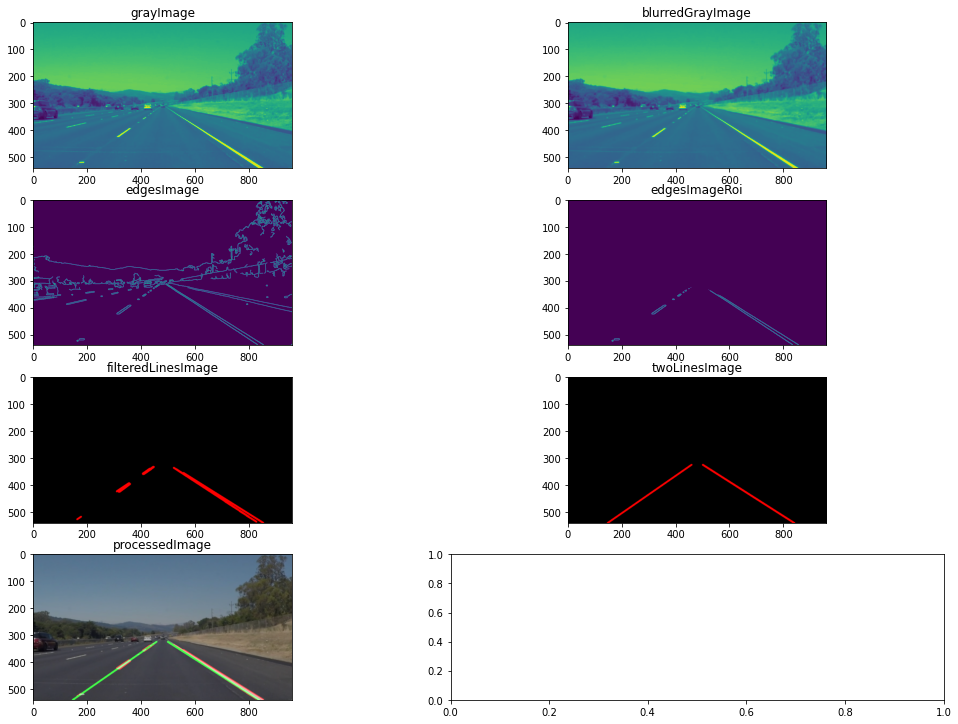

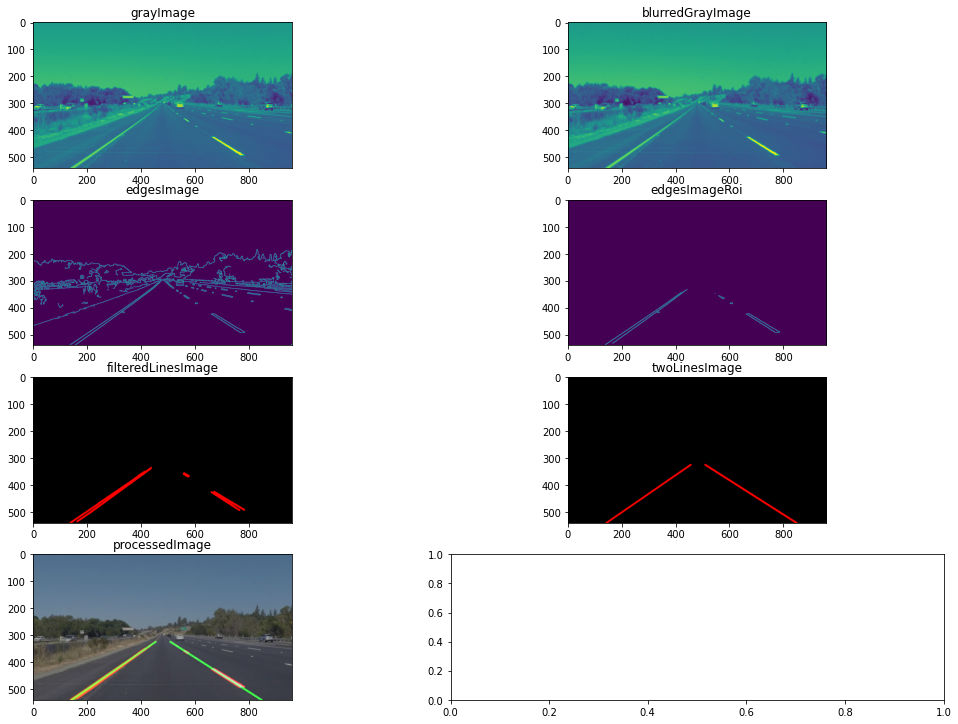

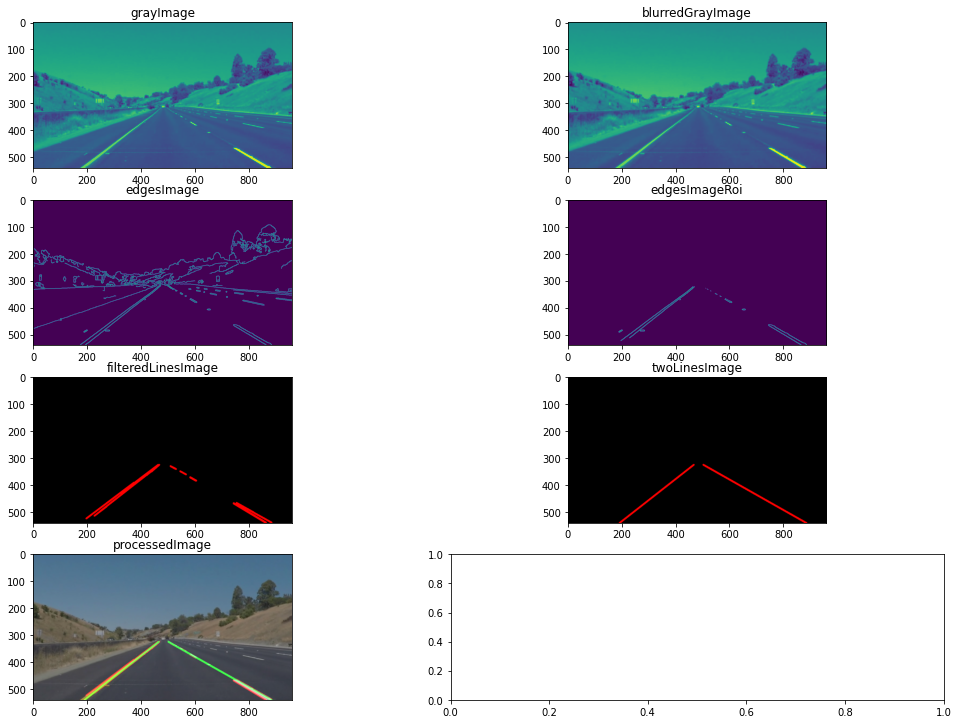

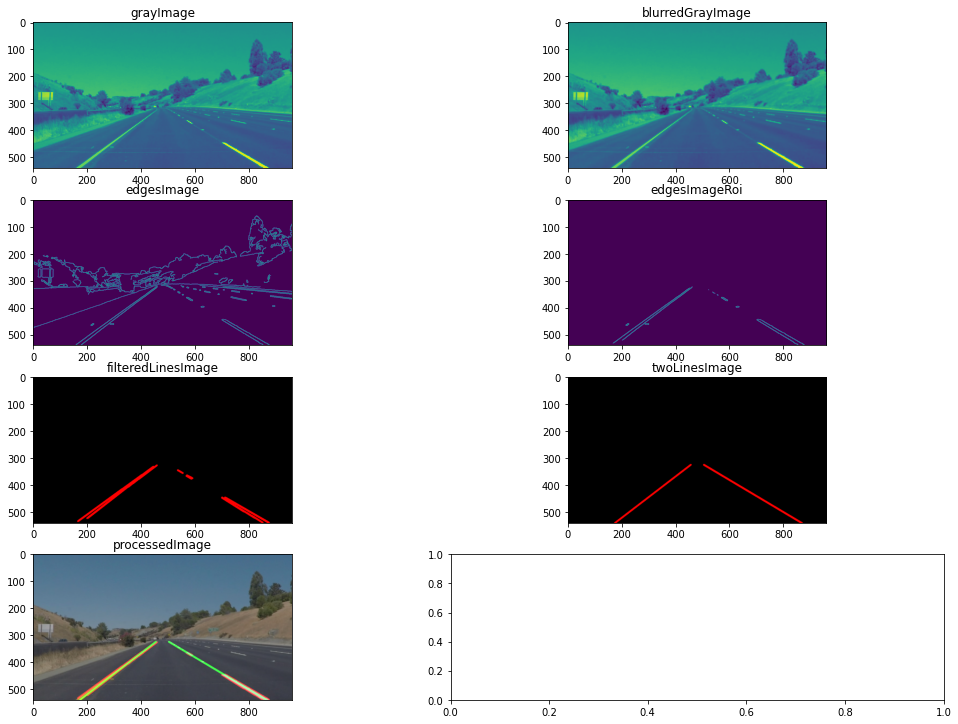

In [8]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = getImages()

for image in images:
    processedImage = process_image(image, True)

-0.7175676081210691
656.3948885125882
*****
0.581598897993721
36.35312536409021
*****
-0.768497988568579
676.9372100061163
*****
0.5657554139552612
37.83250561154194
*****
-0.6937362794360881
641.8300286409388
*****
0.6349860534357209
6.785150383796579
*****
-0.6876205055657708
637.1500923111668
*****
0.6340575955105193
1.7841691713878942
*****
-0.7841974566515014
689.5991601580209
*****
0.5637863175985175
41.33938734558994
*****
-0.764991240953472
672.6851338463028
*****
0.5944156855600617
24.422054863704144
*****


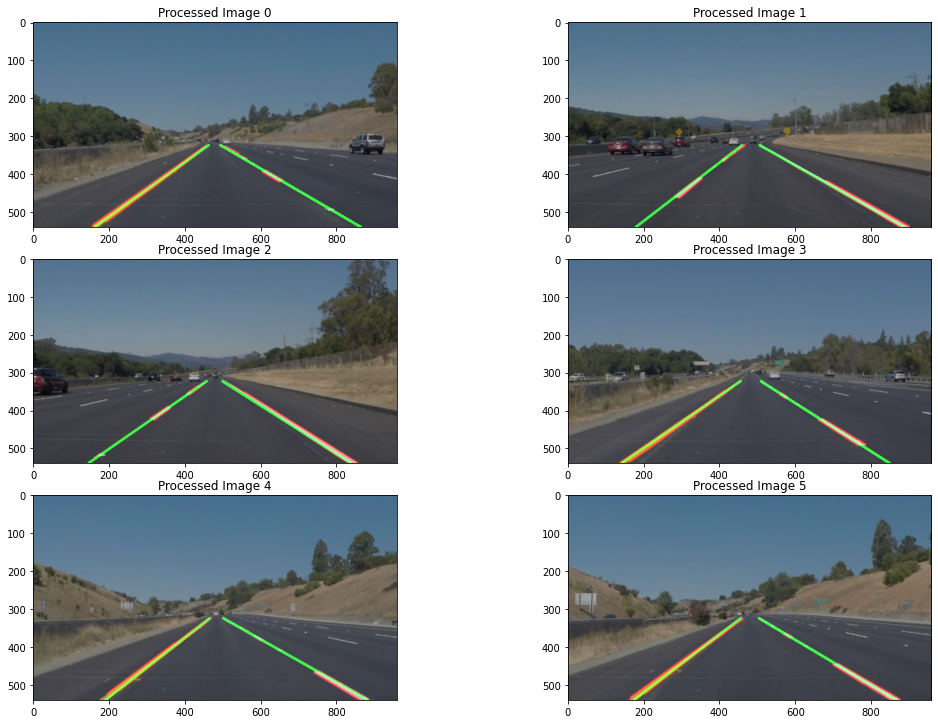

In [9]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
images = getImages()

fig, axs = plt.subplots(int((len(images)+1)/2), 2, figsize=(15, 10))
fig.tight_layout()

for i in range(len(images)):
    image = images[i]
    processedImage = process_image(image)
    axs[int(i/2)][i%2].imshow(processedImage) 
    axs[int(i/2)][i%2].set_title('Processed Image {}'.format(i))

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [11]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

t:   6%|▋         | 14/221 [00:00<00:01, 133.31it/s, now=None]

-0.7259409874621257
652.5068563449677
*****
0.6191100890171229
7.603103936437717
*****
Moviepy - Building video test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video test_videos_output/solidWhiteRight.mp4

-0.7259409874621257
652.5068563449677
*****
0.6191100890171229
7.603103936437717
*****
-0.7288897612068312
652.1897007506961
*****
0.6210143721568684
6.4365636049188355
*****
-0.709790805281651
645.8309339457916
*****
0.6080901257169298
14.676817919313585
*****
-0.7289220963296922
652.082918967092
*****
0.6144204219939542
10.720882624824426
*****
-0.7134858532231174
647.1160176353977
*****
0.6186939849062445
6.047579255460335
*****
-0.6969361035585591
639.7977432461912
*****
0.6143479823500553
12.546728856947183
*****
-0.707764405255934
644.47496277336
*****
0.6120475344151749
13.41609785059264
*****
-0.7186882934936484
648.4652890179782
*****
0.6261070046581634
-0.7681212407899759
*****
-0.7245126131719705
650.1714512534976
*****
0.5969787349214551
20.39523366115018
*****


t:  19%|█▉        | 42/221 [00:00<00:01, 135.19it/s, now=None]

-0.7072017683863517
645.2430100223257
*****
0.636069746599046
1.8260314472516284
*****
-0.7277479482873165
653.5005423220427
*****
0.6442939548523038
-4.1504539616867815
*****
-0.7094235877141641
648.496018156049
*****
0.6356004736079407
1.856796440995416
*****
-0.6957205414130931
641.6819049069228
*****
0.6374568222644748
0.33856206475613965
*****
-0.7269441220679235
654.3414617789665
*****
0.636252725832128
0.5110525793422149
*****
-0.7460559566866142
661.0256496617634
*****
0.6266883209689966
8.440819126610842
*****
-0.6784560363713149
633.3415907649575
*****
0.6396591637137103
-0.9277062917878279
*****
-0.703721758032071
644.2326958283755
*****
0.6359077416975256
-0.4364773486974691
*****
-0.7097576488257705
645.3697780790549
*****
0.6357061574696965
-0.3262404152592288
*****
-0.7281652093775184
653.3270092312849
*****
0.6317170487642364
3.12458947668112
*****
-0.7050246362171515
646.3903678077787
*****
0.6373574749417434
0.07871882768477977
*****
-0.7064902100053109
644.8834860562

t:  28%|██▊       | 62/221 [00:00<00:01, 110.81it/s, now=None]

-0.7050676249617525
642.4486370444921
*****
0.6494063191380979
-9.142314297142072
*****
-0.69828380396637
637.4014136866082
*****
0.6687145182334635
-22.679924694316146
*****
-0.7229320876921129
646.2378129124146
*****
0.6341222353957687
0.9202918712583907
*****
-0.6969373541830828
637.8055550846916
*****
0.6524409566207582
-12.605353419174916
*****
-0.7035643110754397
638.4876615236151
*****
0.6585178542576858
-14.833236839491791
*****
-0.7083124540979536
642.1164728630724
*****
0.6376233928932903
-1.5021948324944538
*****
-0.658228912769913
622.3333641007717
*****
0.6389120514106679
-2.2695412575965856
*****
-0.6877802638807801
632.4291631053502
*****
0.6309174428843167
5.739588102761673
*****
-0.6979271990731813
638.9168882043242
*****
0.6387784238693379
1.963683623087871
*****
-0.6985048314625788
638.7440721010034
*****
0.6515974007897513
-7.336487790553252
*****
-0.6641906494209804
626.2854812015357
*****
0.6258883478339721
8.9776964218369
*****
-0.6763332029891722
630.16238458052

t:  38%|███▊      | 84/221 [00:00<00:01, 103.32it/s, now=None]

-0.6596570412786843
622.346867457945
*****
0.6476026894428797
-0.8738336723440919
*****
-0.6823285800220589
630.4678270894134
*****
0.64967397061541
-4.73317641593603
*****
-0.6519598175472145
618.0597411061774
*****
0.6764916707097486
-20.562141881005513
*****
-0.7057793722830578
639.5505726811945
*****
0.6604677923289292
-11.13025614006543
*****
-0.6677990518866636
624.7864944223429
*****
0.6606641306807091
-12.846000989414781
*****
-0.6848562287790377
631.176859148809
*****
0.6658871780451375
-16.74517039502227
*****
-0.6714038724461783
624.9076257407633
*****
0.6542226581839298
-7.804874712044588
*****
-0.6687265601609029
625.6640333400469
*****
0.660716012099743
-13.062550991195705
*****
-0.6598698772138956
620.6804533846589
*****
0.6578747289607868
-9.299886840879003
*****
-0.6538280898621264
618.6992350068684
*****
0.6604913142453784
-8.985480091807108
*****
-0.6636155562194422
622.5612169197312
*****
0.6713280725640373
-12.353413207744289
*****
-0.6344473388605454
612.737628782

t:  48%|████▊     | 107/221 [00:00<00:01, 106.28it/s, now=None]

-0.6429846101292732
614.7591569200576
*****
0.6891203763599655
-24.998758038722116
*****
-0.6518053361523157
618.7979850186373
*****
0.6940365077958265
-28.27413174195931
*****
-0.6539284031658633
620.6876274338141
*****
0.6954329291098542
-29.874024860579738
*****
-0.6528084381818139
621.0098279160777
*****
0.7081376003260671
-35.34943311549415
*****
-0.6453913599594355
618.6412922220231
*****
0.7008272168170927
-30.192802940898407
*****
-0.6157112308969758
606.3773751583635
*****
0.7085311076532629
-36.261240318647694
*****
-0.6188010455055813
607.8370801102777
*****
0.7125736653636355
-42.647931736607106
*****
-0.65479937946903
620.2485350949811
*****
0.6672551983753633
-16.20491539290591
*****
-0.6626644112788558
622.2529824853872
*****
0.6995294882734941
-34.503426730672466
*****
-0.653658560654076
618.2605457325668
*****
0.7064219987045833
-38.449582079785436
*****
-0.6412069616911124
613.6866664514429
*****
0.6986036734782585
-36.551765695248676
*****
-0.6495715684415743
618.294

t:  58%|█████▊    | 129/221 [00:01<00:00, 102.20it/s, now=None]

-0.6866477151654539
636.2941454140819
*****
0.6927901698416726
-32.4892240450241
*****
-0.6641239920017367
625.1097736947115
*****
0.6855305344007366
-29.17421528373624
*****
-0.6895871573684269
636.6470490474275
*****
0.6864905345081056
-31.890430154076164
*****
-0.7028704552058772
641.3446469311647
*****
0.6809507983170076
-27.43682681929824
*****
-0.675519281126797
630.4367265259931
*****
0.6903486116369385
-37.920156131012504
*****
-0.6683580580569826
627.5446159475326
*****
0.6809039020830191
-32.45825680608107
*****
-0.6579623837542269
623.999184025327
*****
0.6873809421173928
-35.19612000753272
*****
-0.6644441553645466
625.2096035835523
*****
0.6574051118745605
-12.30648203035551
*****
-0.6617646448958572
625.1915709669397
*****
0.67504167523446
-23.761681628313287
*****
-0.6637704577248889
626.8071377778739
*****
0.6733636190320337
-25.00169134181589
*****
-0.6666113028183817
627.5040936232729
*****
0.666427680125593
-23.668043926658587
*****
-0.663947603204464
629.94665803651

t:  68%|██████▊   | 151/221 [00:01<00:00, 101.64it/s, now=None]

-0.723964931404655
655.5044233122804
*****
0.6366227653464973
-2.567811566553171
*****
-0.6953913937839058
644.2851170564256
*****
0.6344365729528175
-0.4951184319595488
*****
-0.7022606851150273
645.0347771285651
*****
0.6454056232597555
-11.34153777712796
*****
-0.6839077043375441
637.3735004424032
*****
0.6542949116809176
-12.994781542412214
*****
-0.6904526464064584
639.4787519602506
*****
0.6365132810856575
-4.828639689367785
*****
-0.7028190949165053
643.4988923032994
*****
0.62956569375379
-0.6452568362918893
*****
-0.7029317678110708
643.7094546461506
*****
0.631043108186993
-3.398748151975915
*****
-0.7002173977497071
643.3953789004861
*****
0.608850626502884
14.272622481937612
*****
-0.6991074707808075
643.5949522963504
*****
0.6105169160413076
13.574001029630717
*****
-0.7060899693454388
647.9670673404913
*****
0.6317987583580654
1.728239851262873
*****
-0.7150537548094928
652.4107982181051
*****
0.6378149485758037
-2.9400253415871007
*****
-0.7100287874169877
651.9777225520

t:  78%|███████▊  | 173/221 [00:01<00:00, 100.88it/s, now=None]

-0.7306068041773326
659.2176990758334
*****
0.6280454686743703
-1.3518127231913022
*****
-0.7417495410224526
662.9035389093743
*****
0.6217022580405703
5.010111853120721
*****
-0.7129655824058254
651.1529102415303
*****
0.6037514615005509
13.22398690808525
*****
-0.7293677405367044
656.3603423080118
*****
0.6347118255258447
-8.11367161593483
*****
-0.7146262379840492
650.8214974718926
*****
0.635177118873782
-9.785917022604986
*****
-0.7534791917979533
666.9652030880726
*****
0.6334902932174279
-6.047764225101802
*****
-0.7315580347665167
657.8268014492796
*****
0.6136078416820637
7.497954091496916
*****
-0.7289897543016113
658.6061860362884
*****
0.5901940872536334
21.49683236937487
*****
-0.7323374480155075
662.1498602265032
*****
0.6163567836654626
3.1765842335083003
*****
-0.7297081339133791
661.279667114515
*****
0.6079180620414391
8.55263674776637
*****
-0.7769313833389755
680.7511932190445
*****
0.610052334139515
5.1365627862388425
*****
-0.7508770751222257
670.1943735791498
***

t:  83%|████████▎ | 184/221 [00:01<00:00, 101.94it/s, now=None]

-0.7645484435135022
675.835542519482
*****
0.5925762629387908
19.689135836935534
*****
-0.8038565656865505
692.0614492966905
*****
0.583987726778587
27.43416120997226
*****
-0.7755624331663264
680.7244856145729
*****
0.593567745291442
15.999529602286943
*****
-0.776615185898596
681.5711557635987
*****
0.5959060625082581
18.462883885166104
*****
-0.7782798855061098
681.8845676785862
*****
0.5882268053087251
24.60673607651065
*****
-0.8127274033899398
696.4094338111574
*****
0.5810407044349144
29.205829915799747
*****
-0.835337928591006
704.2517267890955
*****
0.5897839195749581
20.829255897684934
*****
-0.8202227283429889
698.7279610564561
*****
0.5800851505965536
31.663127718408738
*****
-0.8115549383615426
695.3884881867631
*****
0.5896242024379096
20.89346046999012
*****
-0.8119731850234135
695.5525307811828
*****
0.5648482749198007
37.66757504292715
*****
-0.8121009458765829
694.5053095005305
*****
0.632184742038015
-4.051987051658093
*****
-0.7661064374433721
676.7704654271241
****

t:  93%|█████████▎| 206/221 [00:01<00:00, 100.29it/s, now=None]

-0.8297440300178751
701.7902899499069
*****
0.5713105599998954
32.339137402960915
*****
-0.7817065129913995
684.0903401784506
*****
0.5863518401807007
22.40842464293087
*****
-0.7889913675657876
686.775347944272
*****
0.5854816282929656
24.399691082151964
*****
-0.7916771149267975
687.6426148724753
*****
0.5821525058637994
24.4312673125466
*****
-0.8042713114995018
690.8474912468334
*****
0.5834130212605513
23.451307399705946
*****
-0.8005448708742395
689.0956979318181
*****
0.5904178735412128
20.228444743809714
*****
-0.7958499611256726
687.4731977225956
*****
0.5980366856965301
14.242712422378741
*****
-0.834122830886273
702.4040356307182
*****
0.5771579798992624
29.627939622729574
*****
-0.7995739970713774
688.3691728347442
*****
0.5943568192903536
15.528329293025722
*****
-0.7496122152570656
667.8091122392888
*****
0.5888591693672539
19.673363454886513
*****
-0.7823818935532816
680.8881699297526
*****
0.5711282305393172
33.161530249535744
*****
-0.8181792154629407
692.9643864274337

-0.7705358035447621
678.3247466985287
*****
0.566658073366173
35.566054595747794
*****
-0.7439390768242803
667.8804385852644
*****
0.5697311105107027
36.2693014551332
*****
-0.7740314736369786
680.3779799536821
*****
0.5691322717403295
35.270298654417836
*****
-0.7755058148992728
680.7318761389223
*****
0.5581234894632474
41.84696472358329
*****
-0.7992423573129595
688.6322645483725
*****
0.5573981326538165
46.74535398618553
*****
-0.7837112710490405
684.1384343073676
*****
0.5675229783823234
37.61103026051089
*****
-0.7856570709187808
684.2663751004366
*****
0.5691284368288
36.48062815631201
*****
Moviepy - Done !
Moviepy - video ready test_videos_output/solidWhiteRight.mp4
CPU times: user 6.04 s, sys: 288 ms, total: 6.33 s
Wall time: 2.32 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [21]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

t:   2%|▏         | 14/681 [00:00<00:05, 132.41it/s, now=None]

Normal
Normal
Moviepy - Building video test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video test_videos_output/solidYellowLeft.mp4

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:   6%|▋         | 44/681 [00:00<00:04, 138.61it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  10%|▉         | 65/681 [00:00<00:05, 109.94it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  13%|█▎        | 86/681 [00:00<00:05, 104.29it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  16%|█▌        | 106/681 [00:00<00:05, 101.46it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  19%|█▊        | 127/681 [00:01<00:05, 98.88it/s, now=None] 

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  22%|██▏       | 148/681 [00:01<00:05, 99.45it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  25%|██▍       | 168/681 [00:01<00:05, 98.99it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  28%|██▊       | 189/681 [00:01<00:04, 99.21it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  31%|███       | 209/681 [00:02<00:04, 95.34it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  34%|███▎      | 229/681 [00:02<00:04, 92.91it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  37%|███▋      | 251/681 [00:02<00:04, 97.18it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  38%|███▊      | 261/681 [00:02<00:04, 95.18it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal

t:  41%|████▏     | 282/681 [00:02<00:04, 97.88it/s, now=None]


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal

t:  44%|████▍     | 303/681 [00:02<00:03, 98.82it/s, now=None]


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  48%|████▊     | 324/681 [00:03<00:03, 98.72it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  51%|█████     | 345/681 [00:03<00:03, 97.97it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  54%|█████▍    | 367/681 [00:03<00:03, 98.85it/s, now=None] 

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  57%|█████▋    | 388/681 [00:03<00:02, 98.55it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  60%|██████    | 409/681 [00:04<00:02, 99.14it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  63%|██████▎   | 430/681 [00:04<00:02, 99.49it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  66%|██████▌   | 451/681 [00:04<00:02, 99.56it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  69%|██████▉   | 471/681 [00:04<00:02, 95.85it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  72%|███████▏  | 491/681 [00:04<00:01, 96.05it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  75%|███████▌  | 511/681 [00:05<00:01, 96.32it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  78%|███████▊  | 531/681 [00:05<00:01, 92.33it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  79%|███████▉  | 541/681 [00:05<00:01, 91.60it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  82%|████████▏ | 561/681 [00:05<00:01, 93.57it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal

t:  85%|████████▌ | 582/681 [00:05<00:01, 93.51it/s, now=None]


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal

t:  89%|████████▊ | 603/681 [00:06<00:00, 95.38it/s, now=None]


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  91%|█████████▏| 623/681 [00:06<00:00, 96.76it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal

t:  95%|█████████▍| 644/681 [00:06<00:00, 99.72it/s, now=None]


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal

t:  98%|█████████▊| 665/681 [00:06<00:00, 99.40it/s, now=None]


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Moviepy - Done !
Moviepy - video ready test_videos_output/solidYellowLeft.mp4
CPU times: user 20.3 s, sys: 804 ms, total: 21.1 s
Wall time: 7.13 s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5) 
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

t:   4%|▎         | 9/251 [00:00<00:02, 85.12it/s, now=None]

Normal
Normal
Moviepy - Building video test_videos_output/challenge.mp4.
Moviepy - Writing video test_videos_output/challenge.mp4

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  10%|█         | 26/251 [00:00<00:02, 84.47it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


t:  17%|█▋        | 43/251 [00:00<00:02, 82.58it/s, now=None]

Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal
Normal


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))